<a href="https://colab.research.google.com/github/merucode/RL/blob/31-Colab-Study-Udemy-Custom_ENV_snake_game/01_Creating_a_Gym_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___

<a href='http://www.pieriandata.com'><img src='https://github.com/merucode/RL/blob/Pierian_Data_Logo.png?raw=1'/></a>
___
<center><em>Copyright by Pierian Data Inc.</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Creating an Open AI Gym Environment

**IMPORTANT NOTE! YOU NEED TO PIP INSTALL YOUR SNAKE FILE FIRST WITH:**

    pip install -e snake


In [1]:
!git clone -b 31-Colab-Study-Udemy-Custom_ENV_snake_game https://github.com/merucode/RL.git
!cd RL && mv * ../
!pip install -e snake

Cloning into 'RL'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 40.87 KiB | 1.63 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Obtaining file:///content/snake
  Preparing metadata (setup.py) ... done
  Running setup.py develop for gymsnake


After install snake, Restart runtime

In [1]:
import time
import matplotlib.pyplot as plt
import gym

In [2]:
env = gym.make("snake:snake-v0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


0 False {'score': 0}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'numpy.ndarray'>
  logger.warn(f"{pre

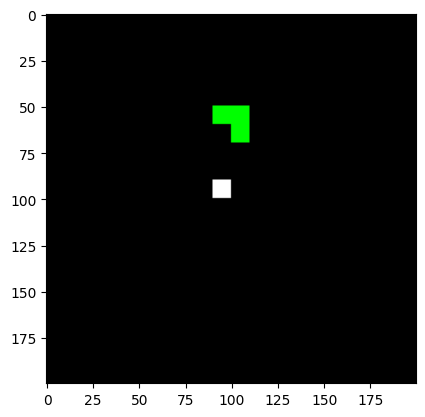

In [3]:
env.reset()
env.render(mode="human")
action = env.action_space.sample()
img, reward, done, info = env.step(1)
print(reward, done, info)
plt.figure()
plt.imshow(img)

In [4]:
env.reset()
for i in range(100):
    env.render(mode="human")
    action = env.action_space.sample()
    img, reward, done, info = env.step(action)
    time.sleep(0.1)